# Solve 2D initial/boundary value problem

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve
from scipy.sparse.csgraph import reverse_cuthill_mckee
from scipy.linalg import lu
from scipy.optimize import root_scalar
from numpy.linalg import inv
from collections import defaultdict
from scipy.linalg import solve
import pandas as pd]
from matplotlib.tri import Triangulation

## 1D Gaussian Quadrature: Standard and Arbitrary Intervals

In [5]:
# ----------------------------------
# Gaussian Quadrature (2–5 points)
# ----------------------------------
# Computes the integral of a function g over [-1,1] using Gauss quadrature
# Supports 2, 3, 4, and 5 point rules

def gaussQuadStd1d(g, noOfIntegPt):
    if noOfIntegPt == 2:
        points = np.array([-1/np.sqrt(3), 1/np.sqrt(3)])
        weights = np.array([1, 1])
    elif noOfIntegPt == 3:
        points = np.array([-np.sqrt(3/5), 0, np.sqrt(3/5)])
        weights = np.array([5/9, 8/9, 5/9])
    elif noOfIntegPt == 4:
        points = np.array([-0.86113631159, -0.33998104358, 0.33998104358, 0.86113631159])
        weights = np.array([0.34785484513, 0.65214515486, 0.65214515486, 0.34785484513])
    elif noOfIntegPt == 5:
        points = np.array([-0.90617984594, -0.53846931011, 0.0, 0.53846931011, 0.90617984594])
        weights = np.array([0.23692688505, 0.47862867049, 0.56888888889, 0.47862867049, 0.23692688505])
    else:
        raise ValueError("Only 2, 3, 4, or 5-point Gaussian quadrature is supported.")

    integral = sum(weights[i] * g(points[i]) for i in range(noOfIntegPt))
    return integral

def gaussQuad1d(fn, lowerLimit, upperLimit, noOfIntegPt):
    def transformed_fn(xi):
        x = (upperLimit + lowerLimit) / 2 + (upperLimit - lowerLimit) / 2 * xi
        return fn(x)

    integral_std = gaussQuadStd1d(transformed_fn, noOfIntegPt)
    return (upperLimit - lowerLimit) / 2 * integral_std

## Midpoint of Curve

In [7]:
# ----------------------------------
# Midpoint of Curve
# ----------------------------------
# Finds the midpoint of a curve y = f(x) from x1 to x2 using arc length
# Integrates sqrt(1 + (f')^2) and solves for xm such that length(x1 to xm) = total length / 2

def midPtCurve(f, fder, x1, x2):
    def integrand(x):
        return (1 + fder(x)**2)**0.5

    total_len = gaussQuad1d(integrand, x1, x2, 5)

    def half_arc_length(xm):
        return gaussQuad1d(integrand, x1, xm, 5) - total_len / 2

    sol = root_scalar(half_arc_length, method='brentq', bracket=[x1, x2])
    xm = sol.root
    ym = f(xm)
    return xm, ym

## Mesh Refinement: Regular Subdivision of Triangles

In [9]:
def refine(nodes0,triangles0,edges0,bdyNode0,bdyEdge0,curveEdge0,bdyFn,bdyFnder):
    nodes = nodes0.copy()
    triangles = triangles0.copy()
    edges = edges0.copy()
    bdyNode = bdyNode0.copy()
    bdyEdge = bdyEdge0.copy()
    curveEdge = curveEdge0.copy()
    noTri = np.shape(triangles)[0] # no of triangles
    noNode = np.shape(nodes)[0] # no of nodes
    parentNodes = np.array([]).reshape((0,2)) # track where the midpoint is from
    # go through triangles to get midpoints
    for k in range(0,noTri):
        node1 = triangles[k,0]
        node2 = triangles[k,1]
        node3 = triangles[k,2]
        # check the first edge
        inEdges = (np.sum((edges == node1)+(edges == node2),axis=1)==2) # find where the first edge is in the edge list
        if (np.sum(inEdges)): # if found
            edgeNo = np.where(inEdges)[0] # which edge it is
            # find midpoint
            if (curveEdge[edgeNo[0]] == 1): # if it is a curve edge
                x1m,y1m = midPtCurve(bdyFn,bdyFnder,nodes[node1-1,0],nodes[node2-1,0])
            else:
                x1m = 0.5*(nodes[node1-1,0]+nodes[node2-1,0])
                y1m = 0.5*(nodes[node1-1,1]+nodes[node2-1,1])
            # endif curveEdge
            nodes,edges,bdyNode,bdyEdge,curveEdge = updateTri(x1m,y1m,node1,node2,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)
            numNode = len(nodes[:,0])
            nodeNo4MidPt1 = numNode # record the node number of the 1st midpoint
            parentNodes = np.vstack((parentNodes,[node1,node2])) # record the parents that produce this midpoints
        else: # not in existing edges
            # find the node number for the 1st midpoint
            nodeNo4MidPt1 = noNode + np.where(np.sum((parentNodes==node1)+(parentNodes==node2),axis=1)==2)[0][0]+1
        inEdges = (np.sum((edges==node2)+(edges==node3),axis=1)==2) # find where the second edge is in the edge list
        if (np.sum(inEdges)): # if found
            edgeNo = np.where(inEdges)[0] # which edge it is
            # find midpoint
            if (curveEdge[edgeNo[0]] == 1): # if it is a curve edge
                x2m,y2m = midPtCurve(bdyFn,bdyFnder,nodes[node2-1,0],nodes[node3-1,0])
            else:
                x2m = 0.5*(nodes[node2-1,0]+nodes[node3-1,0])
                y2m = 0.5*(nodes[node2-1,1]+nodes[node3-1,1])
            # endif curveEdge
            nodes,edges,bdyNode,bdyEdge,curveEdge = updateTri(x2m,y2m,node2,node3,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)
            numNode = len(nodes[:,0])
            nodeNo4MidPt2 = numNode # record the node number of the 2nd midpoint
            parentNodes = np.vstack((parentNodes,[node2, node3])) # record the parents that produce this midpoints
        else: # not in existing edges
            nodeNo4MidPt2 = noNode + np.where(np.sum((parentNodes==node2)+(parentNodes==node3),axis=1)==2)[0][0]+1
        inEdges = (np.sum((edges==node1)+(edges==node3),axis=1)==2) # find where the third edge is in the edge list
        if (np.sum(inEdges)): # if found
            edgeNo = np.where(inEdges)[0] # which edge it is
            # find midpoint
            if (curveEdge[edgeNo[0]] == 1): # if it is a curve edge
                x3m,y3m = midPtCurve(bdyFn,bdyFnder,nodes[node1-1,0],nodes[node3-1,0])
            else:
                x3m = 0.5*(nodes[node1-1,0]+nodes[node3-1,0])
                y3m = 0.5*(nodes[node1-1,1]+nodes[node3-1,1])
            # endif curveEdge
            nodes,edges,bdyNode,bdyEdge,curveEdge = updateTri(x3m,y3m,node1,node3,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge)
            numNode = len(nodes[:,0])
            nodeNo4MidPt3 = numNode # record the node number of the 3rd midpoint
            parentNodes = np.vstack((parentNodes,[node1, node3])) # record the parents that produce this midpoints
        else: # not in existing edges
            # find the node number for the 3rd midpoint
            nodeNo4MidPt3 = noNode + np.where(np.sum((parentNodes==node1)+(parentNodes==node3),axis=1)==2)[0][0]+1
        # endif inEdges

        # put the 3 new edges in (connecting 3 midpoints)
        edges = np.vstack((edges,[[nodeNo4MidPt1, nodeNo4MidPt2],[nodeNo4MidPt2, nodeNo4MidPt3],[nodeNo4MidPt1, nodeNo4MidPt3]]))
        bdyEdge = np.hstack((bdyEdge,[0,0,0]))
        curveEdge = np.hstack((curveEdge,[0,0,0]))

        # replace this triangle in the triangle list by 4 new triangles
        triangles[k,:] = np.array([node1, nodeNo4MidPt1, nodeNo4MidPt3])
        triangles = np.vstack((triangles,[node2, nodeNo4MidPt2, nodeNo4MidPt1]))
        triangles = np.vstack((triangles,[node3, nodeNo4MidPt3, nodeNo4MidPt2]))
        triangles = np.vstack((triangles,[nodeNo4MidPt1, nodeNo4MidPt2, nodeNo4MidPt3]))
    # endfor all triangles
    return nodes, triangles, edges, bdyNode, bdyEdge, curveEdge

def updateTri(xm,ym,parentNode1,parentNode2,edgeNo,nodes,edges,bdyNode,bdyEdge,curveEdge):

    # add the midpoint to nodes
    nodes = np.vstack((nodes, [xm, ym]))
    row = len(nodes[:,1])
    # replace the original edge by 2 new edges
    edges[edgeNo,:] = np.array([parentNode1, row])
    edges = np.vstack((edges,[parentNode2, row]))
    # if the parent nodes are on a bdyEdge, then this midpoint is a boundary
    # node and both new edges are boundary edges
    if (bdyEdge[edgeNo] == 1):
        bdyNode = np.hstack((bdyNode,[1]))
        bdyEdge = np.hstack((bdyEdge,[1]))
    else:
        bdyNode = np.hstack((bdyNode,[0]))
        bdyEdge = np.hstack((bdyEdge,[0]))
    # endif boundary edge
    # update curveEdge for two new edges
    if (curveEdge[edgeNo] == 1):
        curveEdge = np.hstack((curveEdge,[1]))
    else:
        curveEdge = np.hstack((curveEdge,[0]))
    # endif curveEdge
    return nodes,edges,bdyNode.astype(bool),bdyEdge.astype(bool),curveEdge

## 2D Shape Functions and Their Gradients

In [11]:
def shapeFn2dTs(i: int,x,y,p: int):

    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    # find which points are inside the standard triangle
    ind = (x>= -1.0e-12) & (y >= -1.0e-12) & (y+x -1 <= 1.0e-12)
    # prepare output array
    z = np.zeros(x.shape)
    if (p == 1): # linear shape function
        match i:
            case 1:
                z[ind] = 1 - x[ind] - y[ind]
            case 2:
                z[ind] = x[ind]
            case 3:
                z[ind] = y[ind]
            case _:
                print(f' wrong input on i')
    else: # p==2 quadratic shape function
        match i:
            case 1:
                z[ind] = (1. - x[ind] - y[ind]) * (1. - 2.*x[ind] - 2.*y[ind])
            case 2:
                z[ind] = x[ind] * (2.*x[ind] - 1.)
            case 3:
                z[ind] = y[ind] * (2.*y[ind] - 1.)
            case 4:
                z[ind] = 4. * x[ind] * (1.-x[ind]-y[ind])
            case 5:
                z[ind] = 4. * x[ind] * y[ind]
            case 6:
                z[ind] = 4. * y[ind] * (1. -x[ind]-y[ind])
            case _:
                print(f' wrong input on i')
    return z

def shapeFn2d(i: int,x,y,x0,y0,x1,y1,x2,y2,p: int):

    XI = ((y2-y0)*(x-x0)+(x0-x2)*(y-y0)) / ((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
    ETA =((y0-y1)*(x-x0)+(x1-x0)*(y-y0)) / ((x1-x0)*(y2-y0)-(x2-x0)*(y1-y0))
    z = shapeFn2dTs(i,XI,ETA,p)
    return z

def shapeFnGrad2dTs(i:int,xi,eta,p:int):
    
    xi = np.atleast_1d(xi)
    eta = np.atleast_1d(eta)
    # find which points are inside the standard triangle
    ind = (xi>= -1.0e-12) & (eta >= -1.0e-12) & (eta+xi -1 <= 1.0e-12)
    # prepare output array
    psi_xi = np.zeros(xi.shape)
    psi_eta = np.zeros(eta.shape)
    # shape function order
    if (p == 1): # linear shape function
        match i: # which shape function
            case 1:
                psi_xi[ind] = -1.
                psi_eta[ind] = -1.
            case 2:
                psi_xi[ind] = 1.
                psi_eta[ind] = 0.
            case 3:
                psi_xi[ind] = 0.
                psi_eta[ind] = 1.
            case _:
                print(f' wrong input on i')
    else: # p== 2 quadratic shape function
        match i: # which shape function
            case 1:
                psi_xi[ind] = -3. + 4.*xi[ind] + 4.*eta[ind]
                psi_eta[ind] = -3. + 4.*xi[ind] + 4.*eta[ind]
            case 2:
                psi_xi[ind] = 4.*xi[ind] - 1.
                psi_eta[ind] = 0.
            case 3:
                psi_xi[ind] = 0.
                psi_eta[ind] = 4.*eta[ind] - 1.
            case 4:
                psi_xi[ind] = 4. - 8.*xi[ind] - 4.*eta[ind]
                psi_eta[ind] = -4.*xi[ind]
            case 5:
                psi_xi[ind] = 4.*eta[ind]
                psi_eta[ind] = 4.*xi[ind]
            case 6:
                psi_xi[ind] = -4.*eta[ind]
                psi_eta[ind] = 4. - 4.*xi[ind] - 8.*eta[ind]
            case _:
                print(f' wrong input on i')
    return psi_xi, psi_eta

def shapeFnGrad2d(i:int,x,y,x0,y0,x1,y1,x2,y2,p:int):
 
    # map to standard triangle coordinates
    xi = ((y2-y0) * (x-x0) + (x0-x2) * (y-y0)) / ((x1-x0) * (y2-y0) - (x2-x0) * (y1-y0))
    eta =((y0-y1) * (x-x0) + (x1-x0) * (y-y0)) / ((x1-x0) * (y2-y0) - (x2-x0) * (y1-y0))
    #print(f'{xi},{eta}')
    # find deriavtives on standard triangle
    a,b=shapeFnGrad2dTs(i,xi,eta,p)
    # multiply by Jacobian
    psi_x = (((y2-y0) * a + (y0-y1) * b) / ((x1-x0) * (y2-y0) - (x2-x0) * (y1-y0)))
    psi_y = (((x0-x2) * a + (x1-x0) * b) / ((x1-x0) * (y2-y0) - (x2-x0) * (y1-y0)))
    gradpsi = np.vstack((psi_x, psi_y))
    return gradpsi

## 2D Gaussian Quadrature on Triangular Elements

In [13]:
def quad2dTs(g, noOfIntegPt):
    if noOfIntegPt == 1:
        pts = [(1/3, 1/3, 1/2)]
    elif noOfIntegPt == 3:
        pts = [(1/2, 0, 1/6),
               (1/2, 1/2, 1/6),
               (0, 1/2, 1/6)]
    elif noOfIntegPt == 4:
        pts = [(1/3, 1/3, -9/32), 
               (3/5, 1/5, 25/96), 
               (1/5, 3/5, 25/96), 
               (1/5, 1/5, 25/96)]
    elif noOfIntegPt == 6:
        pts = [(1280/1567, 287/3134, 137/2492), 
               (287/3134, 1280/1567, 137/2492), 
               (287/3134, 287/3134, 137/2492), 
               (575/5319, 2372/5319, 1049/9392), 
               (2372/5319, 575/5319, 1049/9392), 
               (2372/5319, 2372/5319, 1049/9392)]
    elif noOfIntegPt == 7:
        pts = [(1/3, 1/3, 9/80), 
               (248/311, 496/4897, 352/5590),
               (496/4897, 248/311, 352/5590),
               (496/4897, 496/4897, 352/5590),
               (248/4153, 496/1055, 1748/26406),
               (496/1055, 248/4153, 1748/26406),
               (496/1055, 496/1055, 1748/26406)]
    else:
        raise ValueError("Invalid number of integration points")

    val = 0.0
    for xi, eta, w in pts:
        val += w * g(xi, eta)
    return val 

def quad2dTri(f, x1, y1, x2, y2, x3, y3, noOfIntegPt):
    
    J = abs((x2 - x1)*(y3 - y1) - (x3 - x1)*(y2 - y1))
    
    # Define transformed integrand for standard triangle
    def g(xi, eta):
        # Transform from [standard] to [general] coordinates
        x = x1 + (x2 - x1)*xi + (x3 - x1)*eta
        y = y1 + (y2 - y1)*xi + (y3 - y1)*eta
        return f(x, y)
    
    # Compute integral on [standard] triangle
    integral_std = quad2dTs(g, noOfIntegPt)

    val = abs(J) * integral_std
    
    return val

## Assembly of FEM Solution and Gradient in 2D

In [15]:
def approxSol2d(w,g,indVec,nodes,triangles,midNodes,triangleMidPts,shapeFn):
    if (shapeFn == 1): # if linear shape functions are used
        uh = lambda x,y: linearApprox2d(x,y,w,g,indVec,nodes,triangles)
    else: # if quadratic shape functions are used
        uh = lambda x,y: quadraticApprox2d(x,y,w,g,indVec,nodes,triangles,midNodes,triangleMidPts)
    return uh

# assemble linear approximated function
def linearApprox2d(x,y,w,g,indVec,nodes,triangles):
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    noNodes = nodes.shape[0]
    # put all node values together
    uu = np.zeros(noNodes)
    uu[indVec > 0] = w
    # Gamma 1 nodes
    gamma1s = (indVec==0)
    uu[gamma1s] = g(nodes[gamma1s,0],nodes[gamma1s,1])
    # vertices of triangles
    N1 = triangles[:,0]
    N2 = triangles[:,1]
    N3 = triangles[:,2]
    # number of triangles
    notri = len(N1)
    lxr,lxc = x.shape if x.ndim == 2 else (x.size, 1)
    lx = lxr * lxc
    z = np.zeros(lx)
    flat_x = x.ravel()
    flat_y = y.ravel()
    ckNan = np.zeros(lx)
    for i in range(notri):
        x1, y1 = nodes[N1[i]-1]
        x2, y2 = nodes[N2[i]-1]
        x3, y3 = nodes[N3[i]-1]
        psi1 = shapeFn2d(1,flat_x,flat_y,x1,y1,x2,y2,x3,y3,1)
        psi2 = shapeFn2d(2,flat_x,flat_y,x1,y1,x2,y2,x3,y3,1)
        psi3 = shapeFn2d(3,flat_x,flat_y,x1,y1,x2,y2,x3,y3,1)
        ckNan += ((psi1!=0) | (psi2!=0) | (psi3!=0)).astype(float)
        z += uu[N1[i]-1] * psi1 + uu[N2[i]-1] * psi2 + uu[N3[i]-1] * psi3
    z[ckNan.astype(bool)] /= ckNan[ckNan.astype(bool)]
    z[~ckNan.astype(bool)] = np.nan
    z = z.reshape(x.shape)
    return z

# assemble quadratic approximations
def quadraticApprox2d(x,y,w,g,indVec,nodes,triangles,midNodes,triangleMidPts):
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    noVer = nodes.shape[0]
    noNodes = noVer + midNodes.shape[0]
    # put all node values together
    uu = np.zeros(noNodes)
    uu[indVec > 0] = w
    gamma1s = np.where(indVec == 0)[0]
    gamma1nodes = gamma1s[gamma1s < noVer]
    gamma1midNodes = np.setdiff1d(gamma1s,gamma1nodes)
    uu[gamma1nodes] = g(nodes[gamma1nodes, 0], nodes[gamma1nodes, 1])
    uu[gamma1midNodes] = g(midNodes[gamma1midNodes-noVer, 0], midNodes[gamma1midNodes-noVer, 1])
    # all vertices and mid-edge nodes
    N1 = triangles[:,0]
    N2 = triangles[:,1]
    N3 = triangles[:,2]
    N4 = triangleMidPts[:,0]
    N5 = triangleMidPts[:,1]
    N6 = triangleMidPts[:,2]
    notri = len(N1)
    lxr, lxc = x.shape if x.ndim == 2 else (x.size, 1)
    lx = lxr * lxc
    z = np.zeros(lx)
    flat_x = x.ravel()
    flat_y = y.ravel()
    ckNan = np.zeros(lx)
    for i in range(notri):
        x1, y1 = nodes[N1[i]-1]
        x2, y2 = nodes[N2[i]-1]
        x3, y3 = nodes[N3[i]-1]
        psi1 = shapeFn2d(1,flat_x,flat_y,x1, y1, x2, y2, x3, y3, 2)
        psi2 = shapeFn2d(2,flat_x,flat_y,x1, y1, x2, y2, x3, y3, 2)
        psi3 = shapeFn2d(3,flat_x,flat_y,x1, y1, x2, y2, x3, y3, 2)
        psi4 = shapeFn2d(4,flat_x,flat_y,x1, y1, x2, y2, x3, y3, 2)
        psi5 = shapeFn2d(5,flat_x,flat_y,x1, y1, x2, y2, x3, y3, 2)
        psi6 = shapeFn2d(6,flat_x,flat_y,x1, y1, x2, y2, x3, y3, 2)
        ckNan += ((psi1!=0) | (psi2!=0) | (psi3!=0) | (psi4!=0) | (psi5!=0) | (psi6!=0)).astype(float)
        z += uu[N1[i]-1] * psi1 + uu[N2[i]-1] * psi2 + uu[N3[i]-1] * psi3 + uu[N4[i]-1] * psi4 + uu[N5[i]-1] * psi5 + uu[N6[i]-1] * psi6
    z[ckNan.astype(bool)] /= ckNan[ckNan.astype(bool)]
    z[~ckNan.astype(bool)] = np.nan
    z = z.reshape(x.shape)
    return z

def approxSolGrad2d(w,g,indVec,nodes,triangles,midNodes,triangleMidPts,shapeFn):
    if (shapeFn == 1): # if linear shape functions are used
        graduh = lambda x,y: gradLinearApprox2d(x,y,w,g,indVec,nodes,triangles);
    else: # if quadratic shape functions are used
        graduh = lambda x,y: gradQuadraticApprox2d(x,y,w,g,indVec,nodes,triangles,midNodes,triangleMidPts);
    return graduh

def gradLinearApprox2d(x,y,w,g,indVec,nodes,triangles):
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    noNodes = nodes.shape[0]
    # put all node values together
    uu = np.zeros(noNodes)
    uu[indVec > 0] = w
    # Gamma 1 nodes
    gamma1s = (indVec==0)
    uu[gamma1s] = g(nodes[gamma1s,0],nodes[gamma1s,1])
    # vertices of triangles
    N1 = triangles[:,0]
    N2 = triangles[:,1]
    N3 = triangles[:,2]
    # no of triangles
    notri = len(N1)
    lxr,lxc = x.shape if x.ndim == 2 else (x.size, 1)
    lx = lxr * lxc
    gradz = np.zeros((lx, 2), dtype=float)
    flat_x = x.ravel()
    flat_y = y.ravel()
    ckNan = np.zeros(lx, dtype = float)
    for i in range(notri):
        x1, y1 = nodes[N1[i]-1]
        x2, y2 = nodes[N2[i]-1]
        x3, y3 = nodes[N3[i]-1]
        gradpsi1 = shapeFnGrad2d(1,flat_x,flat_y,x1,y1,x2,y2,x3,y3,1).T
        gradpsi2 = shapeFnGrad2d(2,flat_x,flat_y,x1,y1,x2,y2,x3,y3,1).T
        gradpsi3 = shapeFnGrad2d(3,flat_x,flat_y,x1,y1,x2,y2,x3,y3,1).T
        ckNan += np.any((gradpsi1 != 0) | (gradpsi2 != 0) | (gradpsi3 != 0), axis=1).astype(float)
        gradz += (uu[N1[i]-1] * gradpsi1 + uu[N2[i]-1] * gradpsi2 + uu[N3[i]-1] * gradpsi3)
    gradz[ckNan.astype(bool)] /= ckNan[ckNan.astype(bool), np.newaxis]
    gradz[~ckNan.astype(bool)] = np.nan
    return gradz.reshape(lxr,lxc,2)

def gradQuadraticApprox2d(x,y,w,g,indVec,nodes,triangles,midNodes,triangleMidPts):
    x = np.atleast_1d(x)
    y = np.atleast_1d(y)
    noVer = nodes.shape[0]
    noNodes = noVer + midNodes.shape[0]
    # put all node values together
    uu = np.zeros(noNodes)
    uu[indVec > 0] = w
    gamma1s = np.where(indVec == 0)[0]
    gamma1nodes = gamma1s[gamma1s < noVer]
    gamma1midNodes = np.setdiff1d(gamma1s,gamma1nodes)
    uu[gamma1nodes] = g(nodes[gamma1nodes, 0], nodes[gamma1nodes, 1])
    uu[gamma1midNodes] = g(midNodes[gamma1midNodes-noVer, 0], midNodes[gamma1midNodes-noVer, 1])
    # all vertices and mid-edge nodes
    N1 = triangles[:,0]
    N2 = triangles[:,1]
    N3 = triangles[:,2]
    N4 = triangleMidPts[:,0]
    N5 = triangleMidPts[:,1]
    N6 = triangleMidPts[:,2]
    notri = len(N1)
    lxr, lxc = x.shape if x.ndim == 2 else (x.size, 1)
    lx = lxr * lxc
    gradz = np.zeros((lx,2),dtype=float)
    flat_x = x.ravel()
    flat_y = y.ravel()
    ckNan = np.zeros(lx, dtype = float)
    for i in range(notri):
        x1, y1 = nodes[N1[i]-1]
        x2, y2 = nodes[N2[i]-1]
        x3, y3 = nodes[N3[i]-1]
        gradpsi1 = shapeFnGrad2d(1,flat_x,flat_y,x1,y1,x2,y2,x3,y3,2).T
        gradpsi2 = shapeFnGrad2d(2,flat_x,flat_y,x1,y1,x2,y2,x3,y3,2).T
        gradpsi3 = shapeFnGrad2d(3,flat_x,flat_y,x1,y1,x2,y2,x3,y3,2).T
        gradpsi4 = shapeFnGrad2d(4,flat_x,flat_y,x1,y1,x2,y2,x3,y3,2).T
        gradpsi5 = shapeFnGrad2d(5,flat_x,flat_y,x1,y1,x2,y2,x3,y3,2).T
        gradpsi6 = shapeFnGrad2d(6,flat_x,flat_y,x1,y1,x2,y2,x3,y3,2).T
        ckNan += np.any((gradpsi1 != 0) | (gradpsi2 != 0) | (gradpsi3 != 0) | (gradpsi4 != 0) | (gradpsi5 != 0) | (gradpsi6 != 0), axis=1).astype(float)
        gradz += (uu[N1[i]-1] * gradpsi1 + uu[N2[i]-1] * gradpsi2 + uu[N3[i]-1] * gradpsi3 + uu[N4[i]-1] * gradpsi4 + uu[N5[i]-1] * gradpsi5 + uu[N6[i]-1] * gradpsi6)
    gradz[ckNan.astype(bool)] /= ckNan[ckNan.astype(bool), np.newaxis]
    gradz[~ckNan.astype(bool)] = np.nan
    return gradz.reshape(lxr,lxc,2)

## Element Matrix and Load Vector Assembly

In [17]:
def keij2d(k, e, i, j, triangles, nodes, shapeFn, noOfIntegPt):

    # Get triangle vertices
    tri = triangles[e-1] - 1
    x1, y1 = nodes[tri[0]]
    x2, y2 = nodes[tri[1]]
    x3, y3 = nodes[tri[2]]
    
    def integrand(x, y):
        # Calculate gradients of shape functions i and j
        grad_psi_i = shapeFnGrad2d(i, x, y, x1, y1, x2, y2, x3, y3, shapeFn)
        grad_psi_j = shapeFnGrad2d(j, x, y, x1, y1, x2, y2, x3, y3, shapeFn)
        
        # Product of terms in integrand
        return k(x, y) * (grad_psi_i[0]*grad_psi_j[0] + grad_psi_i[1]*grad_psi_j[1])
    
    # Compute integral over the triangle
    z = quad2dTri(integrand, x1, y1, x2, y2, x3, y3, noOfIntegPt)
    
    return z


def fei2d(k, f, g, h, e, i, triangles, nodes, edges,
          triangleMidPts, midNodes, Gamma1Nodes, Gamma1MidNodes, Gamma2Edges,
          shapeFn, noOfIntegPt, noOfIntegPt1d):

    # Get triangle vertices
    tri = triangles[e-1]
    x1, y1 = nodes[tri[0]-1]
    x2, y2 = nodes[tri[1]-1]
    x3, y3 = nodes[tri[2]-1]

    # Part 1: Volume integral of f*ψ_i
    def vol_integrand(x, y):
        return f(x, y) * shapeFn2d(i, x, y, x1, y1, x2, y2, x3, y3, shapeFn)

    fe = quad2dTri(vol_integrand, x1, y1, x2, y2, x3, y3, noOfIntegPt)

    # Part 2: Sum over Dirichlet nodes (subtract g_j * K^e_ij)
    num_local_dofs = 3 if shapeFn == 1 else 6

    for j in range(1, num_local_dofs+1):
        if j <= 3:  # Vertex node
            node_id = tri[j-1]
            if Gamma1Nodes[node_id-1]:
                gj = g(*nodes[node_id-1])
                keij_val = keij2d(k, e, i, j, triangles, nodes, shapeFn, noOfIntegPt)
                fe -= gj * keij_val
        else:  # Mid-edge node (quadratic only)
            if shapeFn == 2:
                mid_id = triangleMidPts[e-1][j-4]  # Get mid-node ID
                # Adjust index for Gamma1MidNodes (assuming midNodes are numbered starting after regular nodes)
                mid_node_index = mid_id - len(nodes) - 1
                if Gamma1MidNodes[mid_node_index]:
                    gj = g(*midNodes[mid_node_index])
                    keij_val = keij2d(k, e, i, j, triangles, nodes, shapeFn, noOfIntegPt)
                    fe -= gj * keij_val

    # Part 3: Neumann boundary terms
    # Get all edges of this element
    element_edges = [
        (tri[0], tri[1]),
        (tri[1], tri[2]),
        (tri[2], tri[0])
    ]

    for edge_idx, edge in enumerate(element_edges):
        # Check if this edge is on Γ2
        sorted_edge = tuple(sorted(edge))
        try:
            global_edge_idx = [tuple(sorted(e)) for e in edges].index(sorted_edge)
        except ValueError:
            continue

        if Gamma2Edges[global_edge_idx]:
            # Get edge endpoints
            n1, n2 = edge
            x1_edge, y1_edge = nodes[n1-1]
            x2_edge, y2_edge = nodes[n2-1]
            edge_length = np.sqrt((x2_edge-x1_edge)**2 + (y2_edge-y1_edge)**2)

            # Parametric representation of the edge
            def edge_param(s):
                return (x1_edge + s*(x2_edge-x1_edge), (y1_edge + s*(y2_edge-y1_edge)))

            # Integrate h*ψ_i along the edge
            def edge_integrand(s):
                x, y = edge_param(s)
                return h(x, y) * shapeFn2d(i, x, y, x1, y1, x2, y2, x3, y3, shapeFn)

            # Use 1D quadrature
            integral = gaussQuad1d(edge_integrand, 0, 1, noOfIntegPt1d)
            fe += edge_length * integral

    return fe

## Global Assembly of Stiffness Matrix and Load Vector

In [19]:
def stiffK2d(k, triangles, nodes, triangleMidPts, indVec, shapeFn, noOfIntegPt):

    n_free_nodes = np.max(indVec)
    K = lil_matrix((n_free_nodes, n_free_nodes))
    
    for e in range(1, len(triangles) + 1):
        n_nodes_per_element = 3 if shapeFn == 1 else 6
        
        for i in range(1, n_nodes_per_element + 1):
            # Get global node index
            if i <= 3:
                global_i = triangles[e-1][i-1]
            else:
                mid_node_idx = triangleMidPts[e-1][i-4] - 1
                if mid_node_idx >= len(triangleMidPts)*3:  # Safety check
                    continue
                global_i = triangleMidPts[e-1][i-4]
            
            if indVec[global_i-1] == 0:
                continue
                
            for j in range(1, n_nodes_per_element + 1):
                if j <= 3:
                    global_j = triangles[e-1][j-1]
                else:
                    mid_node_idx = triangleMidPts[e-1][j-4] - 1
                    if mid_node_idx >= len(triangleMidPts)*3:
                        continue
                    global_j = triangleMidPts[e-1][j-4]
                
                if indVec[global_j-1] == 0:
                    continue
                
                ke_ij = keij2d(k, e, i, j, triangles, nodes, shapeFn, noOfIntegPt)
                K[indVec[global_i-1]-1, indVec[global_j-1]-1] += ke_ij
    
    return K

def loadF2d(k, f, g, h, triangles, nodes, edges, triangleMidPts, midNodes,
            indVec, Gamma1Nodes, Gamma1MidNodes, Gamma2Edges,
            shapeFn, noOfIntegPt, noOfIntegPt1d):

    n_free_nodes = np.max(indVec)
    F = np.zeros(n_free_nodes)

    n_local = 3 if shapeFn == 1 else 6

    for e in range(1, len(triangles) + 1):
        for i in range(1, n_local + 1):
            # Get global node index
            if i <= 3:
                global_i = triangles[e-1][i-1]
            else:
                global_i = triangleMidPts[e-1][i-4]

            if indVec[global_i - 1] == 0:
                continue

            fe_i = fei2d(k, f, g, h, e, i, triangles, nodes, edges,
                         triangleMidPts, midNodes, Gamma1Nodes, Gamma1MidNodes,
                         Gamma2Edges, shapeFn, noOfIntegPt, noOfIntegPt1d)

            F[indVec[global_i - 1] - 1] += fe_i.item()

    return F


## Banded LU Factorization and Solver

In [21]:
#__________________________________
# Banded LU factorization routines
#__________________________________

def bandLU(A, r, s):
    """
    Factorizes a dense banded matrix A (n x n) into LU,
    where r is the number of subdiagonals and s is the number of superdiagonals.
    The factorization is done in place.
    """
    A = A.copy()
    n = A.shape[0]
    for i in range(n):
        for j in range(i+1, min(n, i+r+1)):
            if A[i, i] == 0:
                raise ZeroDivisionError("Zero pivot encountered in LU factorization.")
            A[j, i] /= A[i, i]
            for k in range(i+1, min(n, i+s+1)):
                A[j, k] -= A[j, i] * A[i, k]
    return A

def bandForward(LU, b, r):
    """Solve L y = b with forward substitution; L is stored in LU."""
    n = len(b)
    y = np.zeros_like(b)
    for i in range(n):
        y[i] = b[i]
        for j in range(max(0, i-r), i):
            y[i] -= LU[i, j] * y[j]
    return y

def bandBackward(LU, y, s):
    """Solve U x = y with backward substitution; U is stored in LU."""
    n = len(y)
    x = np.zeros_like(y)
    for i in range(n-1, -1, -1):
        x[i] = y[i]
        for j in range(i+1, min(n, i+s+1)):
            x[i] -= LU[i, j] * x[j]
        if LU[i, i] == 0:
            raise ZeroDivisionError("Zero pivot encountered in backward substitution.")
        x[i] /= LU[i, i]
    return x

## Reverse Cuthill-McKee Reordering

In [23]:
def rcm(A):

    # Convert to CSR format
    A_csr = csr_matrix(A)

    # Compute reverse cuthill mckee permutation
    perm = reverse_cuthill_mckee(A_csr)

    # Compute inverse permutation
    perm_inv =  np.argsort(perm)

    return perm, perm_inv

## 2D Finite Element Solver for Boundary Value Problem (myFE2dbvp)

In [25]:
def myFE2dbvp(k, f, g, h, maxh, nodes, triangles, edges,
              bdyNode, bdyEdge, curveEdge, bdyFn, bdyFnder, shapeFn):

    # Integration settings
    noOfIntegPt = 7
    noOfIntegPt1d = 5
    tol = 1e-12

    # Refine mesh until hMax <= maxh
    while True:
        hMax = max(np.linalg.norm(nodes[e[0] - 1] - nodes[e[1] - 1]) for e in edges)
        if hMax <= maxh:
            break
        nodes, triangles, edges, bdyNode, bdyEdge, curveEdge = refine(
            nodes, triangles, edges, bdyNode, bdyEdge, curveEdge, bdyFn, bdyFnder
        )

    # Mark Dirichlet boundary nodes (Gamma1)
    Gamma1Vertex = np.abs(nodes[:, 1] - bdyFn(nodes[:, 0])) < tol

    # Mark Dirichlet boundary edges (curveEdge)
    curveEdge = np.zeros(len(edges), dtype=bool)
    for i, (n1, n2) in enumerate(edges):
        x1, y1 = nodes[n1 - 1]
        x2, y2 = nodes[n2 - 1]
        if abs(y1 - bdyFn(x1)) < tol and abs(y2 - bdyFn(x2)) < tol:
            curveEdge[i] = True

    # Handle quadratic shape functions (shapeFn == 2)
    if shapeFn == 2:
        edge_to_mid_id = {}
        midNodes = np.zeros((len(edges), 2))
        triangleMidPts = np.zeros((len(triangles), 3), dtype=int)

        for i, (n1, n2) in enumerate(edges):
            edge_to_mid_id[tuple(sorted((n1, n2)))] = i
            midNodes[i] = 0.5 * (nodes[n1 - 1] + nodes[n2 - 1])

        for t, tri in enumerate(triangles):
            for j, (a, b) in enumerate([(0, 1), (1, 2), (2, 0)]):
                edge = tuple(sorted((tri[a], tri[b])))
                triangleMidPts[t, j] = len(nodes) + edge_to_mid_id[edge] + 1

        allNodes = np.vstack([nodes, midNodes])

        # Mark Dirichlet mid-edge nodes
        Gamma1MidNodes = np.zeros(len(midNodes), dtype=bool)
        for i, (n1, n2) in enumerate(edges):
            if bdyEdge[i] and Gamma1Vertex[n1 - 1] and Gamma1Vertex[n2 - 1]:
                Gamma1MidNodes[i] = True

        Gamma1Nodes = Gamma1Vertex

    else:
        triangleMidPts = []
        midNodes = np.zeros((0, 2))
        allNodes = nodes
        Gamma1Nodes = Gamma1Vertex
        Gamma1MidNodes = np.array([], dtype=bool)

    # Mark Neumann boundary edges (Gamma2)
    Gamma2Edges = np.array([
        bdyEdge[i] and not curveEdge[i]
        for i in range(len(edges))
    ])

    # Build index vector for free nodes
    totalNodes = len(allNodes)
    indVec = np.zeros(totalNodes, dtype=int)
    used_flags = np.zeros(totalNodes, dtype=bool)

    for tri in triangles:
        for v in tri[:3]:
            used_flags[v - 1] = True
    if shapeFn == 2:
        for mids in triangleMidPts:
            used_flags[mids - 1] = True

    counter = 1
    allGamma1Nodes = np.concatenate([Gamma1Nodes, Gamma1MidNodes])
    for i in range(totalNodes):
        if i < len(allGamma1Nodes) and not allGamma1Nodes[i] and used_flags[i]:
            indVec[i] = counter
            counter += 1

    # Assemble global stiffness matrix and load vector
    K = stiffK2d(k, triangles, allNodes, triangleMidPts, indVec, shapeFn, noOfIntegPt)
    F = loadF2d(k, f, g, h, triangles, allNodes, edges, triangleMidPts, midNodes,
                indVec, Gamma1Nodes, Gamma1MidNodes, Gamma2Edges, shapeFn,
                noOfIntegPt, noOfIntegPt1d)

    # Solve linear system for free degrees of freedom
    w_free = spsolve(K.tocsc(), F)

    # Recover approximate solution and gradient
    uh = approxSol2d(w_free, g, indVec, nodes, triangles,
                     midNodes, triangleMidPts, shapeFn)
    graduh = approxSolGrad2d(w_free, g, indVec, nodes, triangles,
                             midNodes, triangleMidPts, shapeFn)

    return uh, graduh, hMax, allNodes, triangles, w_free

## Error Norm Computation: H1 and L2 Norms on Triangulated Domains

In [27]:
def H1norm2d(f, gradf, nodes, triangles):
    """
    Compute the H1 norm of a function on a triangulated domain.
    """
    norm_squared = 0.0

    for tri in triangles:
        n1, n2, n3 = tri - 1
        x1, y1 = nodes[n1]
        x2, y2 = nodes[n2]
        x3, y3 = nodes[n3]

        def integrand(x, y):
            val = f(x, y)
            grad = gradf(x, y)
            val_sq = np.asarray(val)**2
            grad_sq = np.sum(np.asarray(grad)**2, axis=-1)
            return val_sq + grad_sq

        norm_squared += quad2dTri(integrand, x1, y1, x2, y2, x3, y3, 7)

    return np.sqrt(norm_squared)

def L2norm2d(f, nodes, triangles):
    """
    Compute the L2 norm of a function on a triangulated domain using H1norm2d.
    """
    zero_grad = lambda x, y: np.zeros((*np.shape(x), 2))
    return H1norm2d(f, zero_grad, nodes, triangles)

## Test Values 

In [30]:
# === Define exact solution and PDE data ===
u_true = lambda x, y: np.sin(y - x**2)
u_true_grad = lambda x, y: np.array([-2 * x * np.cos(y - x**2), np.cos(y - x**2)]).T

k = lambda x, y: y + 1
f = lambda x, y: (2 * y + 1) * np.cos(y - x**2) + (4 * x**2 + 1) * (y + 1) * np.sin(y - x**2)
g = u_true  # Dirichlet boundary condition along the curved boundary y = 1 - x^4

# === Correct Neumann boundary function h(x, y) ===
def h(x, y):
    tol = 1e-12

    # Bottom edge: y = 0, for |x| > 1
    if abs(y - 0.0) < tol and abs(x) > 1.0 - tol:
        return -np.cos(x**2)

    # Left edge: x = -2
    elif abs(x + 2.0) < tol:
        return -4 * (y + 1) * np.cos(y - 4)

    # Right edge: x = 2
    elif abs(x - 2.0) < tol:
        return -4 * (y + 1) * np.cos(y - 4)

    # Top edge: y = 2
    elif abs(y - 2.0) < tol:
        return 3 * np.cos(2 - x**2)

    else:
        return 0.0  # Interior or Dirichlet curve boundary

# === Load mesh ===
mesh = np.load('initial_triangulation.npz')
nodes = mesh['nodes']
triangles = mesh['triangles']
edges = mesh['edges']

# === Define curved boundary function and its derivative ===
bdyFn = lambda x: 1 - x**4
bdyFnder = lambda x: -4 * x**3
tol = 1e-12

# === Identify boundary nodes ===
bdyNode = np.abs(nodes[:, 1] - bdyFn(nodes[:, 0])) < tol

# === Identify boundary edges (edges used by only one triangle) ===
bdyEdge = np.zeros(len(edges), dtype=bool)
for i, (n1, n2) in enumerate(edges):
    count = sum((n1 in tri and n2 in tri) for tri in triangles)
    if count == 1:
        bdyEdge[i] = True

# === Identify curved boundary edges ===
curveEdge = np.zeros(len(edges), dtype=bool)
for i, (n1, n2) in enumerate(edges):
    x1, y1 = nodes[n1 - 1]
    x2, y2 = nodes[n2 - 1]
    if abs(y1 - bdyFn(x1)) < tol and abs(y2 - bdyFn(x2)) < tol:
        curveEdge[i] = True

In [31]:
# def plot_mesh(nodes, triangles, edges, title="Finite Element Mesh"):
#     """Plot mesh with boundary and interior nodes labeled."""
#     triangles_0based = triangles - 1
#     triang = mtri.Triangulation(nodes[:, 0], nodes[:, 1], triangles_0based)
#     fig, ax = plt.subplots(figsize=(10, 8))
#     ax.triplot(triang, 'k-', lw=0.5, alpha=0.5)
#     ax.tripcolor(triang, np.zeros(len(nodes)), edgecolors='k', cmap='Pastel1', alpha=0.5)
    
#     boundary_nodes = np.unique(edges) - 1
#     interior_nodes = np.setdiff1d(np.arange(len(nodes)), boundary_nodes)
    
#     ax.plot(nodes[boundary_nodes, 0], nodes[boundary_nodes, 1], 'ro', markersize=6, label='Boundary Nodes')
#     if len(interior_nodes) > 0:
#         ax.plot(nodes[interior_nodes, 0], nodes[interior_nodes, 1], 'bo', markersize=4, label='Interior Nodes')

#     for i, (x, y) in enumerate(nodes):
#         ax.text(x, y, str(i + 1), color='k', ha='center', va='bottom', fontsize=8)
#     for i, tri_indices in enumerate(triangles_0based):
#         centroid = nodes[tri_indices].mean(axis=0)
#         ax.text(centroid[0], centroid[1], f'T{i + 1}', color='darkgreen', ha='center', va='center', fontsize=8)

#     ax.set_aspect('equal')
#     ax.grid(True, alpha=0.3)
#     ax.set_title(title)
#     ax.legend()
#     plt.tight_layout()
#     plt.show()

# plot_mesh(nodes, triangles, edges, "Initial Triangulation")

In [32]:
shapeFn = 1
maxh = 1.5

uh1a,graduh1a,hMax1a,nodes1a,triangles1a, w1a = myFE2dbvp(k,f,g,h,maxh,
nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder,shapeFn)

print(f'hMax1a = {hMax1a}')
#print(f'w = {w1a}')

ef = lambda x,y: uh1a(x,y) - u_true(x,y)
efgrad = lambda x,y: graduh1a(x,y) - u_true_grad(x,y)
efgrad1 = lambda x,y: np.zeros((*x.shape,2))

L2_1a = H1norm2d(ef, efgrad1, nodes1a, triangles1a)
H1_1a = H1norm2d(ef, efgrad, nodes1a, triangles1a)

print(f"L2_1a = {L2_1a}")
print(f"H1_1a = {H1_1a}")

hMax1a = 1.1086113679008809
L2_1a = [0.53054892]
H1_1a = [[2.82003126]]


In [33]:
shapeFn = 1
maxh = 1

uh1b,graduh1b,hMax1b,nodes1b,triangles1b,w1b = myFE2dbvp(k,f,g,h,maxh,
nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder,shapeFn)

print(f'hMax1b = {hMax1b}')
#print(f'w = {w1b}')

ef = lambda x,y: uh1b(x,y) - u_true(x,y)
efgrad = lambda x,y: graduh1b(x,y) - u_true_grad(x,y)
efgrad1 = lambda x,y: np.zeros((*x.shape,2))

L2_1b = H1norm2d(ef, efgrad1, nodes1b, triangles1b)
H1_1b = H1norm2d(ef, efgrad, nodes1b, triangles1b)

print(f"L2_1b = {L2_1b}")
print(f"H1_1b = {H1_1b}")

hMax1b = 0.5543056839504404
L2_1b = [0.17360088]
H1_1b = [[1.56947189]]


In [34]:
shapeFn = 1
maxh = 0.5

uh1c,graduh1c,hMax1c,nodes1c,triangles1c,w1c = myFE2dbvp(k,f,g,h,maxh,
nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder,shapeFn)

print(f'hMax1c = {hMax1c}')
#print(f'w = {w1c}')

ef = lambda x,y: uh1c(x,y) - u_true(x,y)
efgrad = lambda x,y: graduh1c(x,y) - u_true_grad(x,y)
efgrad1 = lambda x,y: np.zeros((*x.shape,2))

L2_1c = H1norm2d(ef, efgrad1, nodes1c, triangles1c)
H1_1c = H1norm2d(ef, efgrad, nodes1c, triangles1c)

print(f"L2_1c = {L2_1c}")
print(f"H1_1c = {H1_1c}")

hMax1c = 0.2771528419752202
L2_1c = [0.04697466]
H1_1c = [[0.81249733]]


In [35]:
shapeFn = 1
maxh = 0.25

uh1d,graduh1d,hMax1d,nodes1d,triangles1d,w1d = myFE2dbvp(k,f,g,h,maxh,
nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder,shapeFn)

print(f'hMax1d = {hMax1d}')
#print(f'w = {w1d}')

ef = lambda x,y: uh1d(x,y) - u_true(x,y)
efgrad = lambda x,y: graduh1d(x,y) - u_true_grad(x,y)
efgrad1 = lambda x,y: np.zeros((*x.shape,2))

L2_1d = H1norm2d(ef, efgrad1, nodes1d, triangles1d)
H1_1d = H1norm2d(ef, efgrad, nodes1d, triangles1d)

print(f"L2_1d = {L2_1d}")
print(f"H1_1d = {H1_1d}")

hMax1d = 0.1385764209876101
L2_1d = [0.01201639]
H1_1d = [[0.40997026]]


In [36]:
shapeFn = 2
maxh = 1.5

uh2a,graduh2a,hMax2a,nodes2a,triangles2a,w2a = myFE2dbvp(k,f,g,h,maxh,
nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder,shapeFn)

print(f'hMax2a = {hMax2a}')
#print(f'w = {w2a}')

ef = lambda x,y: uh2a(x,y) - u_true(x,y)
efgrad = lambda x,y: graduh2a(x,y) - u_true_grad(x,y)
efgrad1 = lambda x,y: np.zeros((*x.shape,2))

L2_2a = H1norm2d(ef, efgrad1, nodes2a, triangles2a)
H1_2a = H1norm2d(ef, efgrad, nodes2a, triangles2a)

print(f"L2_2a = {L2_2a}")
print(f"H1_2a = {H1_2a}")

hMax2a = 1.1086113679008809
L2_2a = [0.07276878]
H1_2a = [[0.84163154]]


In [37]:
shapeFn = 2
maxh = 1.0

uh2b,graduh2b,hMax2b,nodes2b,triangles2b,w2b = myFE2dbvp(k,f,g,h,maxh,
nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder,shapeFn)

print(f'hMax2b = {hMax2b}')
#print(f'w = {w2b}')

ef = lambda x,y: uh2b(x,y) - u_true(x,y)
efgrad = lambda x,y: graduh2b(x,y) - u_true_grad(x,y)
efgrad1 = lambda x,y: np.zeros((*x.shape,2))

L2_2b = H1norm2d(ef, efgrad1, nodes2b, triangles2b)
H1_2b = H1norm2d(ef, efgrad, nodes2b, triangles2b)

print(f"L2_2b = {L2_2b}")
print(f"H1_2b = {H1_2b}")

hMax2b = 0.5543056839504404
L2_2b = [0.01105111]
H1_2b = [[0.26353116]]


In [38]:
shapeFn = 2
maxh = 0.5

uh2c,graduh2c,hMax2c,nodes2c,triangles2c,w2c = myFE2dbvp(k,f,g,h,maxh,
nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder,shapeFn)

print(f'hMax2c = {hMax2c}')
#print(f'w = {w2c}')

ef = lambda x,y: uh2c(x,y) - u_true(x,y)
efgrad = lambda x,y: graduh2c(x,y) - u_true_grad(x,y)
efgrad1 = lambda x,y: np.zeros((*x.shape,2))

L2_2c = H1norm2d(ef, efgrad1, nodes2c, triangles2c)
H1_2c = H1norm2d(ef, efgrad, nodes2c, triangles2c)

print(f"L2_2c = {L2_2c}")
print(f"H1_2c = {H1_2c}")

hMax2c = 0.2771528419752202
L2_2c = [0.00142239]
H1_2c = [[0.06821937]]


In [39]:
shapeFn = 2
maxh = 0.25

uh2d,graduh2d,hMax2d,nodes2d,triangles2d,w2d = myFE2dbvp(k,f,g,h,maxh,
nodes,triangles,edges,bdyNode,bdyEdge,curveEdge,bdyFn,bdyFnder,shapeFn)

print(f'hMax2d = {hMax2d}')
#print(f'w = {w2d}')

ef = lambda x,y: uh2d(x,y) - u_true(x,y)
efgrad = lambda x,y: graduh2d(x,y) - u_true_grad(x,y)
efgrad1 = lambda x,y: np.zeros((*x.shape,2))

L2_2d = H1norm2d(ef, efgrad1, nodes2d, triangles2d)
H1_2d = H1norm2d(ef, efgrad, nodes2d, triangles2d)

print(f"L2_2d = {L2_2d}")
print(f"H1_2d = {H1_2d}")

hMax2d = 0.1385764209876101
L2_2d = [0.00018162]
H1_2d = [[0.01736146]]


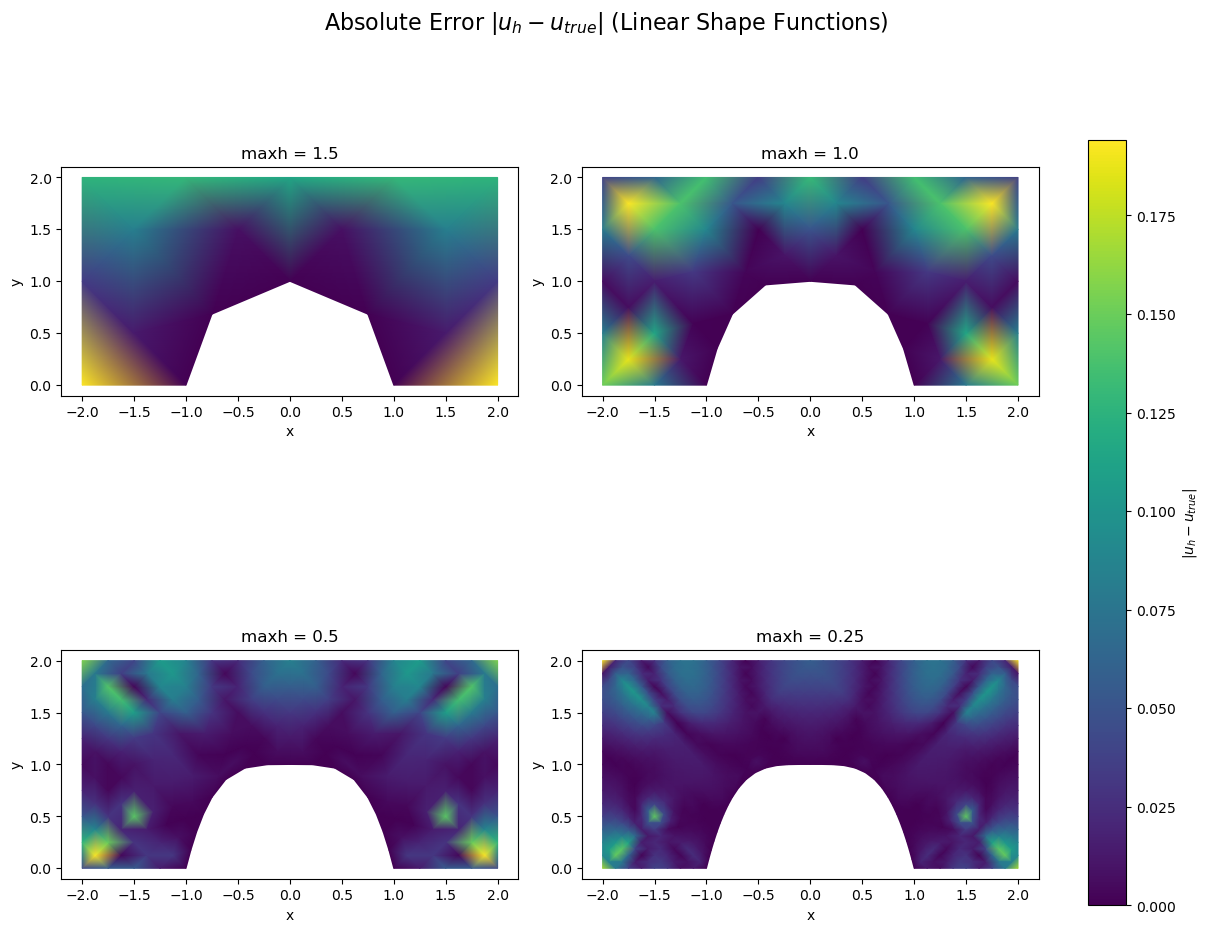

In [93]:
# Utility to make a subplot for one mesh
def plot_abs_error(ax, uh, nodes, triangles, title):
    x = nodes[:, 0]
    y = nodes[:, 1]
    abs_err = np.abs(uh(x, y) - u_true(x, y))
    tri = Triangulation(x, y, triangles - 1)
    tpc = ax.tripcolor(tri, abs_err, shading='gouraud', cmap='viridis')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_aspect('equal')
    return tpc

fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

titles = ["maxh = 1.5", "maxh = 1.0", "maxh = 0.5", "maxh = 0.25"]
uh_list = [uh1a, uh1b, uh1c, uh1d]
nodes_list = [nodes1a, nodes1b, nodes1c, nodes1d]
triangles_list = [triangles1a, triangles1b, triangles1c, triangles1d]

tpcs = []
for ax, uh, nodes, tris, title in zip(axs.flat, uh_list, nodes_list, triangles_list, titles):
    tpc = plot_abs_error(ax, uh, nodes, tris, title)
    tpcs.append(tpc)

# Add a single shared colorbar to the right
fig.suptitle("Absolute Error $|u_h - u_{true}|$ (Linear Shape Functions)", fontsize=16)
cbar = fig.colorbar(tpcs[0], ax=axs, location='right', shrink=0.8, label="$|u_h - u_{true}|$")
cbar.ax.tick_params(labelsize=10)

# Save figure
plt.savefig("abs_error_linear_all_maxh.png", dpi=300)
plt.show()

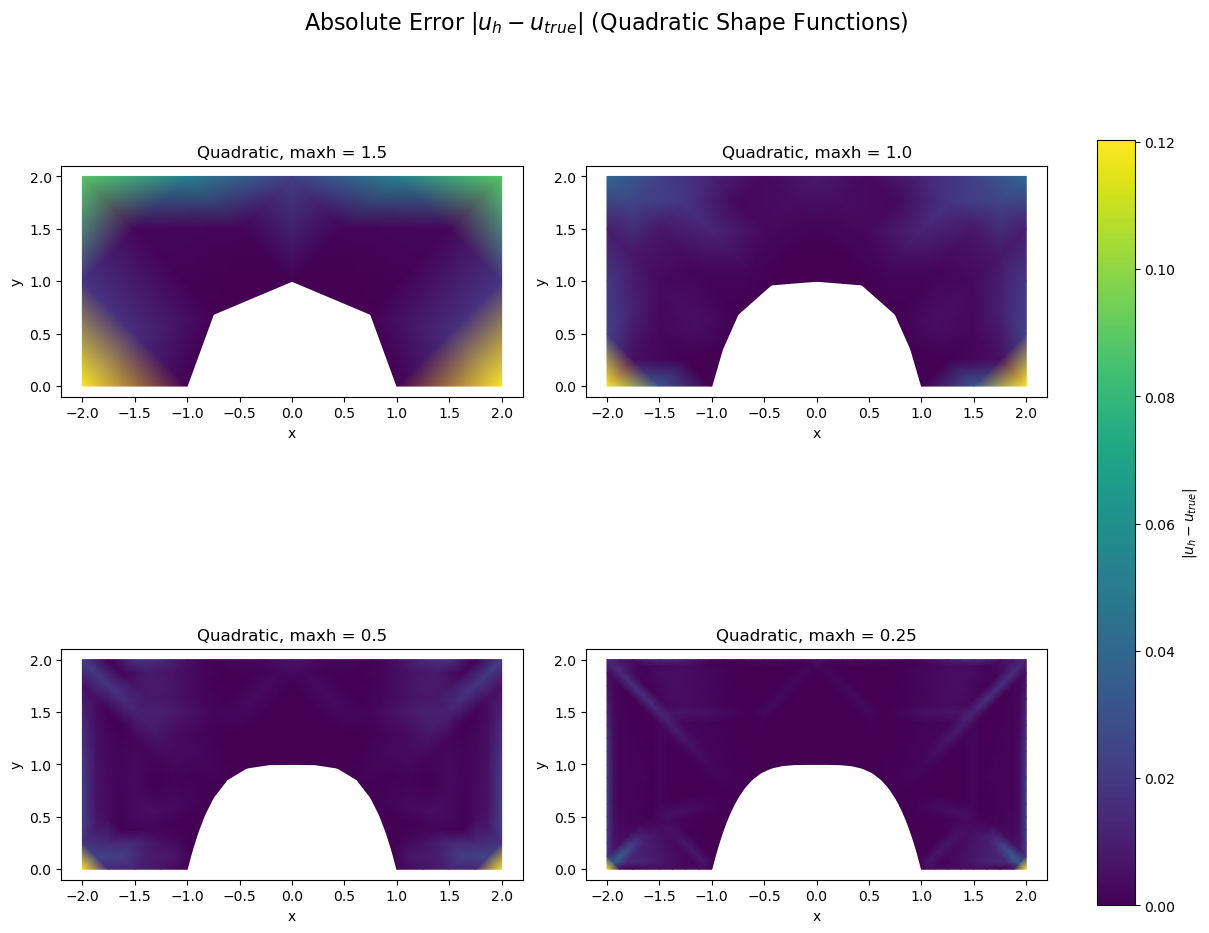

In [95]:
# Set up figure with 2x2 subplots using constrained layout
fig, axs = plt.subplots(2, 2, figsize=(12, 10), constrained_layout=True)

# Data for each subplot
titles = [
    "Quadratic, maxh = 1.5",
    "Quadratic, maxh = 1.0",
    "Quadratic, maxh = 0.5",
    "Quadratic, maxh = 0.25"
]
uh_list = [uh2a, uh2b, uh2c, uh2d]
nodes_list = [nodes2a, nodes2b, nodes2c, nodes2d]
triangles_list = [triangles2a, triangles2b, triangles2c, triangles2d]

# Generate each subplot
tpcs = []
for ax, uh, nodes, tris, title in zip(axs.flat, uh_list, nodes_list, triangles_list, titles):
    tpc = plot_abs_error(ax, uh, nodes, tris, title)
    tpcs.append(tpc)

# Main title and shared colorbar
fig.suptitle("Absolute Error $|u_h - u_{true}|$ (Quadratic Shape Functions)", fontsize=16)
cbar = fig.colorbar(tpcs[0], ax=axs, location='right', shrink=0.8, label="$|u_h - u_{true}|$")
cbar.ax.tick_params(labelsize=10)

# Save and show figure
plt.savefig("abs_error_quadratic_all_maxh.png", dpi=300)
plt.show()

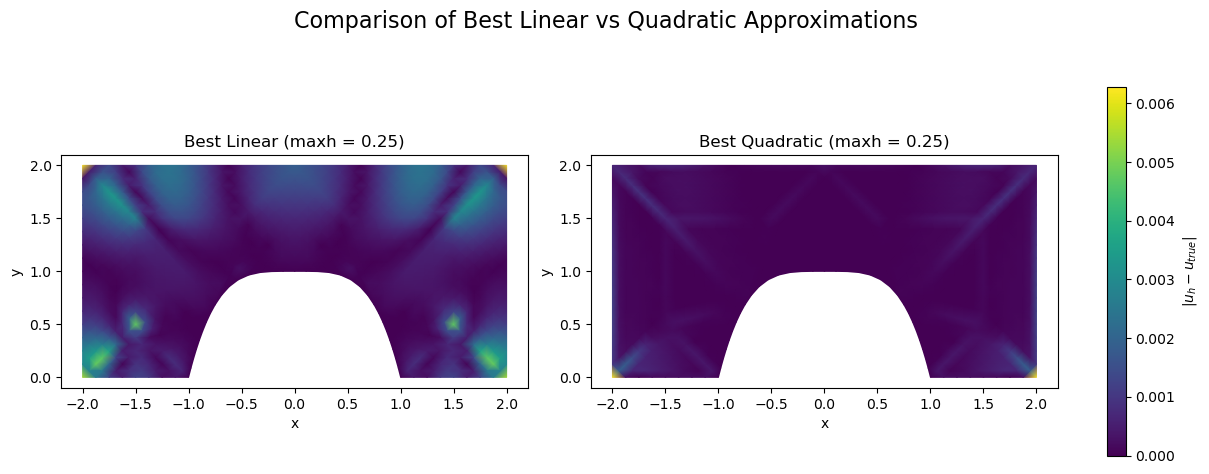

In [97]:
# Create side-by-side subplot layout with better spacing
fig, axs = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Plot both best approximations
titles = ["Best Linear (maxh = 0.25)", "Best Quadratic (maxh = 0.25)"]
uh_list = [uh1d, uh2d]
nodes_list = [nodes1d, nodes2d]
triangles_list = [triangles1d, triangles2d]

tpcs = []
for ax, uh, nodes, tris, title in zip(axs, uh_list, nodes_list, triangles_list, titles):
    tpc = plot_abs_error(ax, uh, nodes, tris, title)
    tpcs.append(tpc)

# Add main title and shared colorbar
fig.suptitle("Comparison of Best Linear vs Quadratic Approximations", fontsize=16)
cbar = fig.colorbar(tpcs[0], ax=axs, location='right', shrink=0.8, label="$|u_h - u_{true}|$")
cbar.ax.tick_params(labelsize=10)

# Save and display
plt.savefig("abs_error_best_linear_vs_quadratic.png", dpi=300)
plt.show()

In [99]:
# Define scalar error results (make sure all values are floats)
data = {
    'ShapeFn':  [1, 1, 1, 1, 2, 2, 2, 2],
    'maxh':     [1.5, 1.0, 0.5, 0.25, 1.5, 1.0, 0.5, 0.25],
    'hMax':     [float(hMax1a), float(hMax1b), float(hMax1c), float(hMax1d),
                 float(hMax2a), float(hMax2b), float(hMax2c), float(hMax2d)],
    'L2 Error': [L2_1a.item(), L2_1b.item(), L2_1c.item(), L2_1d.item(),
                 L2_2a.item(), L2_2b.item(), L2_2c.item(), L2_2d.item()],
    'H1 Error': [H1_1a.item(), H1_1b.item(), H1_1c.item(), H1_1d.item(),
                 H1_2a.item(), H1_2b.item(), H1_2c.item(), H1_2d.item()],
}

# Create DataFrame
df = pd.DataFrame(data)

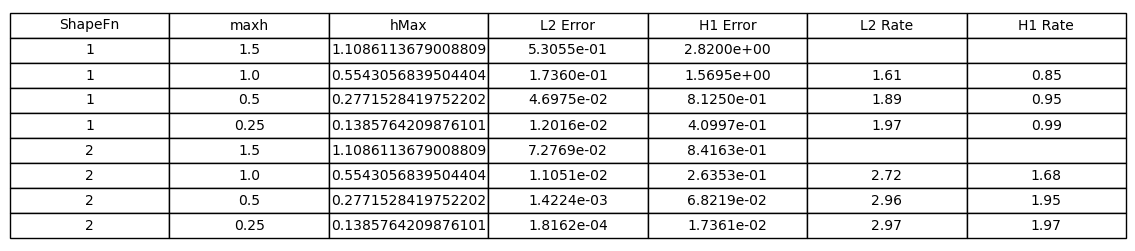

In [101]:
# Function to compute convergence rates (per norm)
def compute_rate(errors, hs):
    rates = [np.nan]
    for i in range(1, len(errors)):
        rate = np.log(errors[i-1] / errors[i]) / np.log(hs[i-1] / hs[i])
        rates.append(rate)
    return rates

# Reset index after filtering
df_linear = df[df['ShapeFn'] == 1].copy().reset_index(drop=True)
df_quad = df[df['ShapeFn'] == 2].copy().reset_index(drop=True)

# Now compute convergence rates safely
df_linear['L2 Rate'] = compute_rate(df_linear['L2 Error'], df_linear['hMax'])
df_linear['H1 Rate'] = compute_rate(df_linear['H1 Error'], df_linear['hMax'])

df_quad['L2 Rate'] = compute_rate(df_quad['L2 Error'], df_quad['hMax'])
df_quad['H1 Rate'] = compute_rate(df_quad['H1 Error'], df_quad['hMax'])

# Combine the results
df = pd.concat([df_linear, df_quad], ignore_index=True)
df
# Format the values for better visual appearance
df_display = df.copy()
df_display['L2 Error'] = df_display['L2 Error'].map("{:.4e}".format)
df_display['H1 Error'] = df_display['H1 Error'].map("{:.4e}".format)
df_display['L2 Rate'] = df_display['L2 Rate'].map(lambda x: f"{x:.2f}" if not pd.isna(x) else "")
df_display['H1 Rate'] = df_display['H1 Rate'].map(lambda x: f"{x:.2f}" if not pd.isna(x) else "")

# Create and save the table as an image
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 3))
ax.axis('off')
table = ax.table(cellText=df_display.values,
                 colLabels=df_display.columns,
                 loc='center',
                 cellLoc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.5)

plt.savefig("fem_convergence_table.png", dpi=300, bbox_inches='tight')
plt.show()